# Task 1

### Global setup, reading in the dataset and checking it has been read in correctly

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Function to load the training and test datasets
# Returns data in the format x_train, y_train, x_test, y_test
def load_dataset():
    train_df = pd.read_csv('traindrug.csv')
    test_df = pd.read_csv('testdrug.csv')

    x_train =  np.asarray(train_df.values[:, 0])
    y_train =  np.asarray(train_df.values[:, 1]).astype(np.int32)
    x_test =  np.asarray(test_df.values[:, 0])
    y_test = np.asarray(test_df.values[:, 1]).astype(np.int32)

    return x_train, y_train, x_test, y_test

In [110]:
x_train, y_train, x_test, y_test = load_dataset()

# Confirming expected data sizes
print("Length: x_train:", len(x_train))
print("Length: y_train:", len(y_train))
print("Length: x_test:", len(x_test))
print("Length: y_test:", len(y_test))

assert len(x_train) == 1000
assert len(y_train) == 1000
assert len(x_test) == 500
assert len(y_test) == 500

Length: x_train: 1000
Length: y_train: 1000
Length: x_test: 500
Length: y_test: 500


### Multilayer Perceptron Part 1 Single vector computed for each input

In [111]:
# Reading in of Google news vectors for text to vec computation
from gensim.models import KeyedVectors
import re

filevec = 'GoogleNews-vectors-negative300.bin'
text2vec = KeyedVectors.load_word2vec_format(filevec, binary=True, limit=50000)

def text2Vec(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in text2vec:
                temp.append(text2vec[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

# Convert x_train and x_test to embedded vectors
x_train_vector = text2Vec(x_train)
x_test_vector = text2Vec(x_test)     


In [112]:
def plot_loss_curve(model_history, plot_title=""):
    """
    Plots the loss curve using a given model's history
    """
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.plot(model_history.history['loss'], label='loss')
    plt.plot(model_history.history['val_loss'], label='val_loss')
    plt.title(plot_title)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.show()

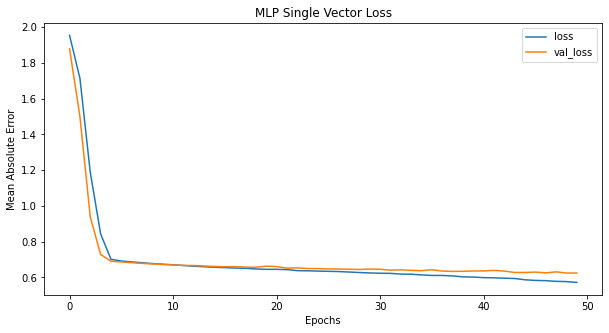

In [158]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a MLP model - not using softmax as I'm just focusing on regression and want to use error metrics
mlp_model = Sequential()
mlp_model.add(Dense(300, input_dim = 300, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(256, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
mlp_model.add(Dropout(0.1))
mlp_model.add(Dense(80, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
mlp_model.add(Dense(1))

opt = Adam(learning_rate=0.0002)

mlp_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['accuracy'])

epochs = 30
history = mlp_model.fit(x_train_vector, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(x_test_vector, y_test))

# Plotting loss curve, final loss results at the end of the document for all models
plot_loss_curve(history, "MLP Single Vector Loss")


### Multilayer Perceptron Part 2 Sequence of Pretrained Vectors

In [114]:
# Convert glove text to word2vec format if it doesn't already exist
# This takes some time
from os.path import exists
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_file = 'glove.6B.300d.txt.word2vec'

if not exists(word2vec_file):
    print("Creating file in glove format")
    glove2word2vec(glove_input_file, word2vec_file)

from gensim.models import KeyedVectors
glove_vectors = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

# Setup tokenizer and fit to training data
# Imports for converting data to tokenized integers for embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)

number_of_words = len(tokenizer.word_index) + 1

# Determine the max word count in a sample in x_train
sentence_word_counts = []
for x in x_train:
    sentence_word_counts.append(len(x.split()))
max_word_count = max(sentence_word_counts) + 10 # Adding more if max_word_count in test is larger 
print("Maximum words in a sentence in x_train:", max_word_count)

# Pad all sequences to the same length
x_train_seq = pad_sequences(sequences=train_sequences, maxlen=max_word_count)

# Also create and pad the sequence for test data
test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences=test_sequences, maxlen=max_word_count)

# Lastly convert all sequences to a numpy float array
x_train_seq = np.asarray(x_train_seq).astype(np.float32)
x_test_seq = np.asarray(x_test_seq).astype(np.float32)

print("Glove loaded and sequences generated for x_train and x_test")

Maximum words in a sentence in x_train: 310
Glove loaded and sequences generated for x_train and x_test


In [115]:
# Define weight matrix for embedding and populate with glove vector at for each word
embedded_weight_matrix = np.zeros((number_of_words, 300))

for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_vector = glove_vectors[word]
        embedded_weight_matrix[i] = embedding_vector

# Test the matrix compare word at index 0
print(embedded_weight_matrix.shape)
# First tokenized word is 'i'
print(np.array_equal(embedded_weight_matrix[1], glove_vectors['i']))

(5626, 300)
True


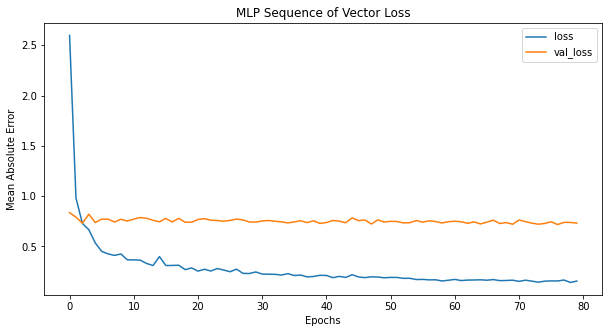

In [162]:
from keras.layers import Embedding, Flatten
from tensorflow.keras.optimizers import Adam

# Define a MLP model with an embedding layer again only focusing on loss
mlp_embedded_model = Sequential()
mlp_embedded_model.add(Embedding(input_dim=number_of_words, output_dim=300, weights=[embedded_weight_matrix], input_length=max_word_count, trainable=False))
mlp_embedded_model.add(Flatten())
mlp_embedded_model.add(Dense(500, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros'))
mlp_embedded_model.add(Dense(80, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros'))
mlp_embedded_model.add(Dense(1, kernel_initializer='he_uniform', bias_initializer='zeros'))

opt = Adam(learning_rate=0.002)

mlp_embedded_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['accuracy'])

epochs = 80
history = mlp_embedded_model.fit(x_train_seq, y_train, epochs=epochs, verbose=0, batch_size=32, validation_data=(x_test_seq, y_test))

plot_loss_curve(history, "MLP Sequence of Vector Loss")

### Convolutional Neural Network Model

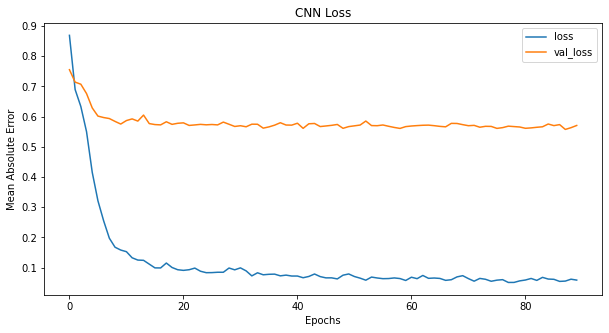

In [175]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

# Define a CNN model using embedding
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=number_of_words, output_dim=300, weights=[embedded_weight_matrix], input_length=max_word_count, trainable=False))
cnn_model.add(Conv1D(filters=512, kernel_size=2, padding='valid', activation='relu', strides=1))
# cnn_model.add(MaxPooling1D(2))
# cnn_model.add(Conv1D(filters=256, kernel_size=2, padding='valid', activation='relu', strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, kernel_initializer='random_uniform', bias_initializer='zeros'))

opt = Adam(learning_rate=0.0005)

cnn_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['accuracy'])

# Run the model against the computed vectors
epochs = 90
history = cnn_model.fit(x_train_seq, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(x_test_seq, y_test))

plot_loss_curve(history, "CNN Loss")


### Recurrent Neural Network Model

In [177]:
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

# Define a model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=number_of_words, output_dim=300, weights=[embedded_weight_matrix], input_length=max_word_count, trainable=False))
rnn_model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.1))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dense(1, kernel_initializer='he_uniform', bias_initializer='zeros'))

opt = Adam(learning_rate=0.001)

rnn_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['accuracy'])

# Run the model against the computed vectors
epochs = 100
history = rnn_model.fit(x_train_seq, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(x_test_seq, y_test))

plot_loss_curve(history, "RNN Loss")

In [ ]:
# Final losss evaluation for each model
print('Task 1 - Final model results loss as MAE')
print("MLP text2vec:")
loss, accuracy = mlp_model.evaluate(x_test_vector, y_test)
print("MLP Glove Embedded:")
loss, accuracy = mlp_embedded_model.evaluate(x_test_seq, y_test)
print("CNN Glove Embedded:")
loss, accuracy = cnn_model.evaluate(x_test_seq, y_test)
print("RNN Glove Embedded:")
loss, accuracy = rnn_model.evaluate(x_test_seq, y_test)

Task 1 - Final model results loss as MAE
MLP text2vec:
16/16 [==============================] - 0s 1ms/step - loss: 0.6247 - accuracy: 0.3280
MLP Glove Embedded:
16/16 [==============================] - 1s 58ms/step - loss: 0.7309 - accuracy: 0.3280
CNN Glove Embedded:
16/16 [==============================] - 1s 37ms/step - loss: 0.5705 - accuracy: 0.3280
RNN Glove Embedded:
16/16 [==============================] - 1s 95ms/step - loss: 0.6465 - accuracy: 0.3280


# Task 2

### Task 2.1

In [125]:
def plot_confusion_matrix(confusion_matrix, labels, plot_title=""):
    """
    Plots a confusion matrix for a given range of class labels 
    """
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.matshow(confusion_matrix, cmap='Blues')
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)

    for (x, y), value in np.ndenumerate(confusion_matrix):
                plt.text(y, x, f"{value:.2f}", va="center", ha="center")


    plt.title(plot_title)
    plt.xlabel("Predicted Class")
    plt.ylabel("Class")
    plt.show()

In [121]:
# Decimal predictions to integer labels
def prediction_decimal_values_to_class_values(y_pred):
    """
    Converts predicted regression values to class labels (1,2,3)
    via clipping and rounding
    """
    y_pred[y_pred < 1.0] = 1
    y_pred[y_pred > 3.0] = 3

    # Rounds values in between to an integer
    y_pred = np.round(y_pred)
    
    # Return as integers
    return y_pred.astype(np.int32)

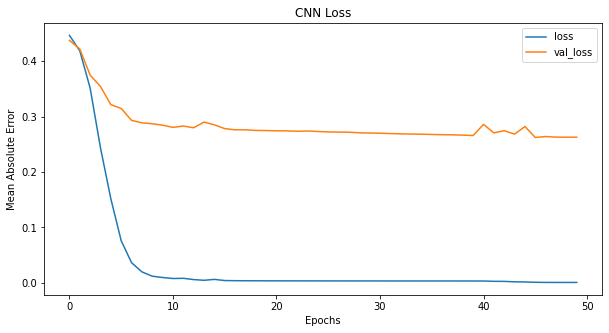

Confusion matrix: 
[[ 70  94   0]
 [ 27 131   7]
 [  6 114  51]]


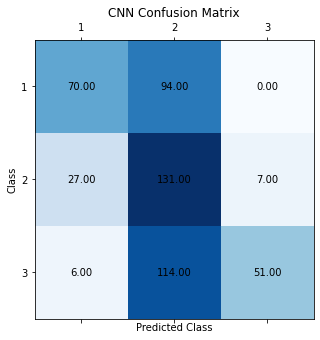

In [145]:
# Evaluate trained CNN model
from sklearn.metrics import confusion_matrix

y_pred = cnn_model.predict(x_test_seq)

y_pred = prediction_decimal_values_to_class_values(y_pred)

# Loss curve
plot_loss_curve(history, "CNN Loss")

# Confusion Matrix
cnn_confusion_matrix = confusion_matrix(y_test, y_pred)

print("Confusion matrix: ")
print(cnn_confusion_matrix)
plot_confusion_matrix(cnn_confusion_matrix, labels=[1,2,3], plot_title="CNN Confusion Matrix")

### Task 2.2

In [146]:
# Re-implementation of the CNN model

from keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define a CNN model using embedding
cnn_model_classify = Sequential()
cnn_model_classify.add(Embedding(input_dim=number_of_words, output_dim=300, weights=[embedded_weight_matrix], input_length=max_word_count, trainable=False))
cnn_model_classify.add(Conv1D(filters=512, kernel_size=2, padding='valid', activation='relu', strides=1))
cnn_model_classify.add(GlobalMaxPooling1D())
cnn_model_classify.add(Dense(128, activation='relu'))
cnn_model_classify.add(Dense(3, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros'))

opt = Adam(learning_rate=0.0005)

# Subtract 1 from all class labels to range of 0-2
y_train_categorial = to_categorical(y_train - 1)
y_test_categorial = to_categorical(y_test - 1)

cnn_model_classify.compile(optimizer=opt, loss='mean_absolute_error', metrics=['accuracy'])
# cnn_model_classify.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Run the model against the computed vectors
epochs = 50
history = cnn_model_classify.fit(x_train_seq, y_train_categorial, epochs=epochs, batch_size=32, verbose=0, validation_data=(x_test_seq, y_test_categorial))

print("CNN with softmax activation successfully trained")

CNN with softmax activation successfully trained


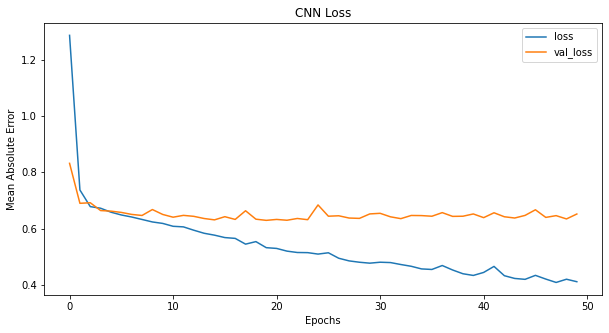

Confusion matrix: 
[[111  37  16]
 [ 46  95  24]
 [ 22  49 100]]


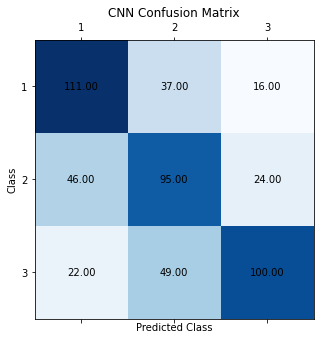

In [148]:
# Evaluation
y_pred_softmax = cnn_model_classify.predict(x_test_seq)

# Calculate the class from max soft max index
# Add 1 to return to 1 based classes (1-3)
y_pred = np.argmax(y_pred_softmax, axis=1) + 1


plot_loss_curve(history, "CNN Loss")

# Confusion Matrix
cnn_confusion_matrix = confusion_matrix(y_test, y_pred)

print("Confusion matrix: ")
print(cnn_confusion_matrix)
plot_confusion_matrix(cnn_confusion_matrix, labels=[1,2,3], plot_title="CNN Confusion Matrix")